# Embed complaints and then use embeddings to predict risk

In [1]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os


In [31]:
# get the API key from the json file
openai.api_key = os.environ.get('OPENAI_API_KEY')

In [58]:
import pandas as pd
import openai
import json

# read in the credit_risk_dataset.json file into a pandas dataframe
df = pd.read_csv('credit_risk_dataset.csv')
# find features with missing values or NaN
print(df.isnull().sum())

# clean the data replace NaN with -99.0
df = df.fillna(-99.0)
#re-order the columns so loan_status is last
cols = list(df.columns.values)
cols.pop(cols.index('loan_status'))
df = df[cols+['loan_status']]
# replace loan_status values 0 with paid and 1 with default
df['loan_status'] = df['loan_status'].replace(0, 'low risk')
df['loan_status'] = df['loan_status'].replace(1, 'high risk')



person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,high risk
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,low risk
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,high risk
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,high risk
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,high risk


In [59]:

# create jsonl file with {"prompt": "data ->", " completion": "loan_status\n\n"} where data is all colums except loan_status
# and loan_status is the value of the loan_status column
# this will be used as the prompt for the GPT-3 model
tdata = []
tstatus = []
for index, row in df.iterrows():
    loan_status = row['loan_status']
    # drop the loan_status column
    row = row.drop('loan_status')
    # convert row to dictionary
    row = row.to_dict()
    # convert dictionary to string
    data = json.dumps(row)
    # remove curly braces
    data = data.replace('{', '')
    data = data.replace('}', '')
    data = data.replace('"', '')
    tdata.append(data)
    tstatus.append(loan_status)

# print length of tdata and tstatus
print(len(tdata))
print(len(tstatus))

32581
32581


In [65]:
import pandas as pd


# create a pandas from tdata and tstatus as columns
df = pd.DataFrame({'data': tdata, 'loan_status': tstatus})
# set mini-df to 1000 rows



65162

In [67]:

# loop over the dataframe and calcula   te the embedding for each row
embeddings = []
mini_df = df[:100]
for index, row in mini_df.iterrows():
    model="text-embedding-ada-002"
    vec = openai.Embedding.create(input = [row['data']], model=model)['data'][0]['embedding']
    embeddings.append(vec)
    #embeddings = np.append(embeddings, [vec], axis=0)
print (len(embeddings[0]))
# write embeddings to a df 
mini_df["embeddings"] = embeddings

mini_df.to_csv('risk_Embed.csv')

1536


/tmp/ipykernel_2282/2171924045.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df["embeddings"] = embeddings


In [68]:
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import numpy as np
from ast import literal_eval
embed = pd.read_csv('risk_Embed.csv')
tsne = TSNE(n_components=2, perplexity=5, random_state=3)
# convert Pandas embedding array to a numpy array of arrays
# The matrix is calculated from the ebmeddings 
matrix = np.array(embed.embeddings.apply(literal_eval).to_list())  # this is the line that takes a while
print(matrix.shape)
X_2d = tsne.fit_transform(matrix)
print(X_2d.shape)


(100, 1536)
(100, 2)


/tmp/ipykernel_2282/194017513.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y,  cmap=colormap, alpha=0.7)


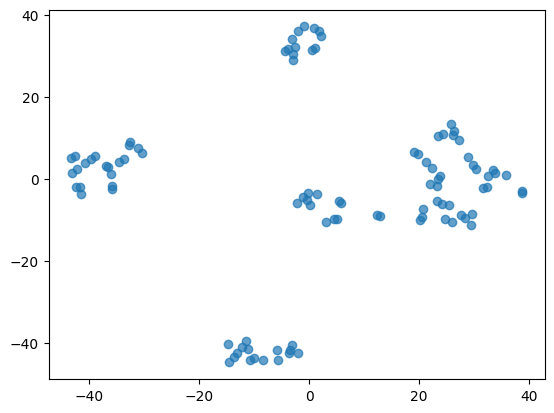

In [69]:
colors = ["red", "darkorange",  "blue", "darkgreen","purple"]
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y,  cmap=colormap, alpha=0.7)
plt.show()

### Dataframe of embeddings causes problems. We need to be careful because "complaints.embeddings" is a Pandas Series and we need a Numpy matrix ie array of arrays. 

In [20]:
# plot the embeddings clusters using TSNE - remember complaints is a dataframe
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import numpy as np
from ast import literal_eval
tsne = TSNE(n_components=2, perplexity=5, random_state=3)

# transform embeddings from list of lists to numpy array of arrays
for i in range(len(embeddings)):
    embeddings[i] = np.array(embeddings[i])
matrix = np.array(embeddings)
print (type(matrix))
print(matrix[0].shape)
# change the shape of the matrix to be 2D (required for TSNE)
matrix = matrix.reshape(-1, 1536)
print(matrix.shape)
X_2d = tsne.fit_transform(matrix)




<class 'numpy.ndarray'>
(1536,)
(20, 1536)


AttributeError: 'list' object has no attribute 'Area'

In [179]:
# split the data into training and test sets for classification of Score from the embeddings
# Score = sentiment,  Area = product category
from sklearn.model_selection import train_test_split

matrix = np.array(complaints.embeddings.apply(literal_eval).to_list())
X_train, X_test, y_train, y_test = train_test_split(
    complaints.embeddings.apply(literal_eval).to_list(),
    complaints.Score.values,  # Score = +1 or -1 AND Area = 0,1,2,3 
    test_size = 0.2,
    random_state=42
)
# print lenght of training set
print(len(X_train))

80


In [180]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10) # n_estimators is the number of trees
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)
print(preds)
# these should be +1 or -1 for the sentiment and Areas 0,1,2,3 for the product categories

[ 0.8 -0.8  1.   1.  -0.8  1.  -0.8 -1.   1.  -1.   0.   0.6 -1.  -1.
  0.4  1.   1.  -1.   1.   1. ]


In [181]:
# compare the predictions to the actual scores
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, preds))
print(rmse)

0.28982753492378877
